# This is a part of the **practical exercise** on uncertainty for dermatoscopy classification. Your task is to go through this tutorial and fill in missing code and answer the questions.

---

First, as usual, we load needed libraries.

---


In [94]:

import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.models import resnet18
from tqdm import tqdm
from torchvision.transforms import ToTensor, Lambda

import numpy as np

In [95]:
! pip install medmnist

---

Now, let's load the dermatoscopy dataset from MedMNIST.

---



In [96]:
import medmnist
from medmnist import INFO, Evaluator

# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# load the data
data_flag = 'dermamnist'
info = INFO[data_flag]
n_classes = len(info['label'])
DataClass = getattr(medmnist, info['python_class'])

train_set = DataClass(split='train', transform=data_transform, download=True)
test_set = DataClass(split='test', transform=data_transform, download=True)
train_set

Using downloaded and verified file: /Users/julienschulz/.medmnist/dermamnist.npz
Using downloaded and verified file: /Users/julienschulz/.medmnist/dermamnist.npz


Dataset DermaMNIST (dermamnist)
    Number of datapoints: 7007
    Root location: /Users/julienschulz/.medmnist
    Split: train
    Task: multi-class
    Number of channels: 3
    Meaning of labels: {'0': 'actinic keratoses and intraepithelial carcinoma', '1': 'basal cell carcinoma', '2': 'benign keratosis-like lesions', '3': 'dermatofibroma', '4': 'melanoma', '5': 'melanocytic nevi', '6': 'vascular lesions'}
    Number of samples: {'train': 7007, 'val': 1003, 'test': 2005}
    Description: The DermaMNIST is based on the HAM10000, a large collection of multi-source dermatoscopic images of common pigmented skin lesions. The dataset consists of 10,015 dermatoscopic images categorized as 7 different diseases, formulized as a multi-class classification task. We split the images into training, validation and test set with a ratio of 7:1:2. The source images of 3×600×450 are resized into 3×28×28.
    License: CC BY-NC 4.0


---

**Q1:** Next, we define objects of *DataLoader* class for training and testing splits. And we also define our model. Here it gets more challenging.

In the cell below you need to:

- load a resnet18 pretrained on ImageNet network from PyTorch
- add a Dropout layer to the last fully-connected layer with 25% probability of neurons to be zeroed
- change the last layer of the resnet18 such that it outputs 7 classes (the number of classes in the dermatoscopy dataset) instead of 1000 classes (as it is in the pretrained network)
- freeze all the layers except the last one, as we are gonna fine tune in the next step our pretrained network on the medical dataset

---

In [97]:
train_batch_size = 40
test_batch_size = 3

train_loader = DataLoader(
    train_set,
    batch_size=train_batch_size,
    num_workers=1,
    pin_memory=True,
)

test_loader = DataLoader(
    test_set,
    batch_size=test_batch_size,
    num_workers=1,
    pin_memory=True,
)

# # PUT YOUR CODE HERE
from torchvision import models
# load model
model = models.resnet18(pretrained=True)

# Add dropout to the classifier
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 512),
    nn.ReLU(),
    nn.Dropout(0.25),  # Dropout layer with 25% chance of zeroing neurons
    nn.Linear(512, n_classes)  # Output layer -> 7
)

# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the classifier (fc layer)
for param in model.fc.parameters():
    param.requires_grad = True



---



Hope you made it work! Now we are gonna fine-tune the model (the last layer of it to be more precise).  

---

In [98]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss = []
model.train()

for epoch in range(5):  # loop over the dataset 5 times to fine-tune the last layer

    running_loss = 0.0
    for i, data in enumerate(tqdm(train_loader), 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # Fix by flattening list and converting back to tensor
        labels = [item[0] for item in labels]
        labels = torch.tensor(labels)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

print('\n Finished training')

100%|██████████| 176/176 [00:45<00:00,  3.87it/s]


 Finished training


**Q2:** What the heck? We got an error (`RuntimeError: 0D or 1D target tensor expected, multi-target not supported`).

Any idea how we can fix it?

---

Let's test the classification accuracy of our model.

**Q3:** Please fill in the missing code below. You need to loop over the test set and compute how many times the trained network predicts the class
correctly.

---

In [104]:
#  set model state to eval() for running the inference
model.eval()

correct = 0
total = 0
correcti = 0
totali = 0

correct_class = [0] * 7
total_class = [0] * 7

with torch.no_grad():
  for images, labels in tqdm(test_loader):

# # PUT YOUR CODE HERE
    labels = [item[0] for item in labels]

    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    
    total += len(predicted)

    for i in range(len(predicted)):
        if predicted[i] == labels[i]:
            correct += 1
            correct_class[labels[i]] += 1
        total_class[labels[i]] += 1


acc = correct / total
acc_class = [correct_class[i] / total_class[i] for i in range(len(correct_class))]
print(f"accuracy: {acc}")
print(f"class specific accuracy: {acc_class}")
print(correct_class)
print(total_class)

100%|██████████| 669/669 [00:10<00:00, 62.36it/s] 

accuracy: 0.6837905236907731
class specific accuracy: [0.16666666666666666, 0.1650485436893204, 0.19545454545454546, 0.0, 0.2242152466367713, 0.9261744966442953, 0.27586206896551724]
[11, 17, 43, 0, 50, 1242, 8]
[66, 103, 220, 23, 223, 1341, 29]


---

The accuracy is ok, but not mindblowing. Thus it would be useful, as discussed in the lecture, to know how confident our model is. Let's use Monte Carlo dropout to find out. We now run 1000 forward passes and look at the distribution of the predictions.

---

In [77]:
saples = 1000
preds = []
image = next(iter(test_loader))

# Fix: set model to train mode to enable dropout
model.train()

# compute predictions from our model with dropout
class_correct = [0] * n_classes
class_total = [0] * n_classes

for idx in range(samples):
    preds.append(model(image[0]).clone().detach().numpy())
ori in range(len()):
     label lass_c[label](predicted[i] == label)lass_[label] += 1ss_[i/iif_t[]!=0erng(n_ca]
nt(f"arcy:{c}"nt("ss-spccacis:"_s):
n(f"Css{i}:{cci}")

In [78]:
pred_class = []
for idx in range(preds.shape[0]):
    pred_class.append(np.argmax(preds[idx],1))

---

Now, we look at the results.

---



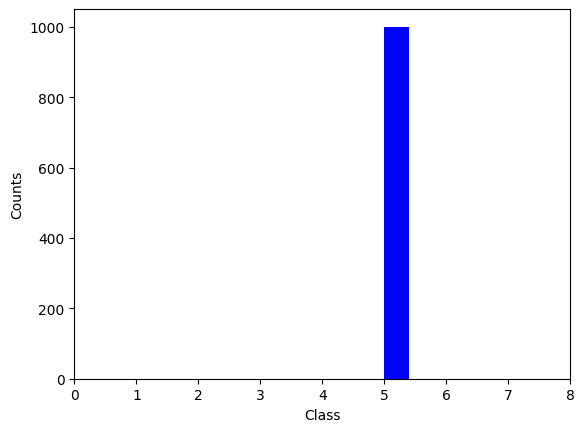

In [79]:
import matplotlib.pyplot as plt

n, bins, patches = plt.hist([x[0] for x in pred_class], facecolor='b', width = 0.4)
plt.xlabel('Class')
plt.ylabel('Counts')
plt.xlim([0,8])
plt.show()

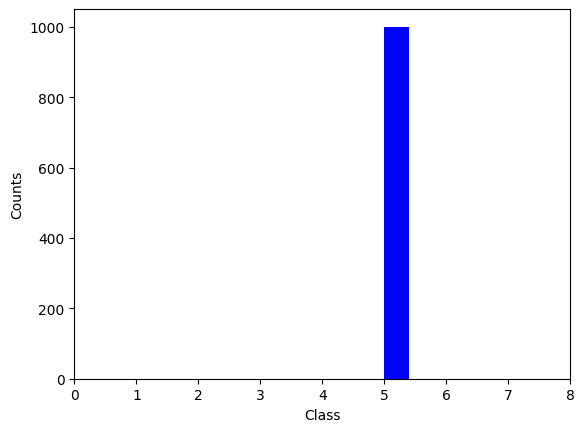

In [80]:
n, bins, patches = plt.hist([x[1] for x in pred_class], facecolor='b', width = 0.4)
plt.xlabel('Class')
plt.ylabel('Counts')
plt.xlim([0,8])
plt.show()

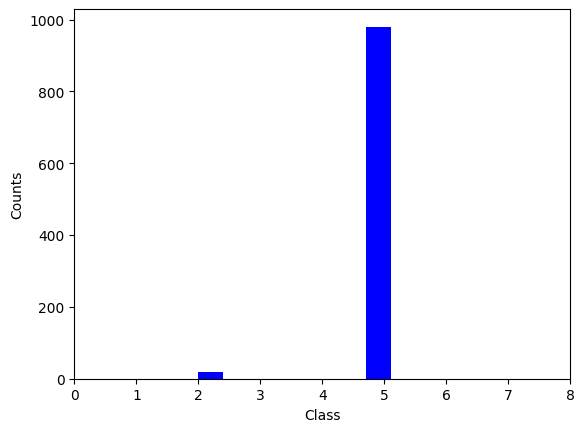

In [81]:
n, bins, patches = plt.hist([x[2] for x in pred_class], facecolor='b', width = 0.4)
plt.xlabel('Class')
plt.ylabel('Counts')
plt.xlim([0,8])
plt.show()

---

Hmm... each time, we predicted the same class 1000 times, but we expected the dropout to provide some distribution of predictions. Suspicuous...

**Q4:** Is there a catch? Please write your thoughts on why we do not see a distribution and whether we could fix it somehow.

---